In [1]:
# 계산
import numpy as np

# 데이터셋 로드 및 정제
import pandas as pd
import gdown

# 전처리
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import scipy as sp

# 출력 및 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus

from sklearn.tree import export_graphviz
from IPython.display import Image
from tqdm import tqdm

# 평가
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 코드 셀 실행 후 경고를 무시
import warnings;warnings.filterwarnings('ignore')

In [2]:
OHLCV_file = "/home/pervinco/Datasets/OHLCV.parquet"
company_file = "/home/pervinco/Datasets/Company.parquet"

OHLCV_data = pd.read_parquet(OHLCV_file)
company_data = pd.read_parquet(company_file)

In [3]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"])
OHLCV_data.reset_index(drop=True, inplace=True)

# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")

OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)

# 파생 변수1 - 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]
# 파생 변수2 - 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] - OHLCV_data["Close"]) / 4
# 파생 변수3 - 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)
# 파생 변수4 - 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)
# 파생 변수5 - 장기, 중기, 단기 이동평균을 파생변수로 추가합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

# 파생 변수6 - 볼린저 밴드(Bolinger bands)는 이동 평균을 기준으로 상한, 하한 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2
std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())
# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

# 파생 변수7 - MACD (Moving Average Convergence & Divergence)는 추가 추세의 힘과 방향성을 파악하여 매매신호를 잡는 목적으로 사용됩니다.
OHLCV_data['ShortEMA'] = OHLCV_data["Close"].ewm(span=12, adjust=False).mean()
OHLCV_data['LongEMA'] = OHLCV_data["Close"].ewm(span=26, adjust=False).mean()
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

In [4]:
# 파생 변수8 - OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.
# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])
# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])
# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])
# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])
# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

# 파생 변수 9 - 시간관련 파생 변수
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.
# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day
# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

In [5]:
# Label Encoding을 진행합니다.
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
industry_label_encoder = LabelEncoder()
OHLCV_data["LEncodedIndustry"] = industry_label_encoder.fit_transform(OHLCV_data["industry"])

code_label_encoder = LabelEncoder()
OHLCV_data["LEncodedCode"] = code_label_encoder.fit_transform(OHLCV_data["code"])

label_encoder = LabelEncoder()
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])

# Frequency Encoding을 진행합니다.
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

# Target Encoding을 진행합니다.
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

In [6]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

OHLCV_data.drop([
    "company", "industry",
    "products", "listing_date", "closing_month",
    "region", "code"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

In [7]:
# 데이터의 날짜 범위를 알아보도록 하겠습니다.

display(f"데이터셋 날짜 범위: {OHLCV_data['Date'].min()} ~ {OHLCV_data['Date'].max()}")

'데이터셋 날짜 범위: 2018-06-28 00:00:00 ~ 2023-07-28 00:00:00'

In [8]:
train_data = OHLCV_data.loc[OHLCV_data["Date"] < "2023-05-01"].reset_index(drop=True)
valid_data = OHLCV_data.loc[OHLCV_data["Date"] >= "2023-05-01"].reset_index(drop=True)

# Date 컬럼은 이제 필요가 없으니 제거하겠습니다.
train_data.drop("Date", axis=1, inplace=True)
valid_data.drop("Date", axis=1, inplace=True)

display(f"학습세트 : {len(train_data)} 개")
display(f"검증세트 : {len(valid_data)} 개")

'학습세트 : 857740 개'

'검증세트 : 45979 개'

In [9]:
# Target컬럼을 학습 데이터셋에서 제거하도록 하겠습니다.
target_col = "Target"
input_cols = list(train_data.columns)
input_cols.remove(target_col)

display(f"Input Featrue : {input_cols}")
display(f"Target : {target_col}")
print("\n")

# 시계열 데이터이기 때문에 인덱스를 기준으로 train/valid를 분할합니다. (랜덤으로 분할하지 않도록 주의하세요!)
X_train = train_data[input_cols]
Y_train = train_data[target_col]

X_valid = valid_data[input_cols]
Y_valid = valid_data[target_col]

display("학습에 사용할 최종 데이터의 형태는 아래와 같습니다.")
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")
display(f"Valid Input : {X_valid.shape}")
display(f"Valid Target : {Y_valid.shape}")

"Input Featrue : ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d', 'LowerBollingerBand', 'UpperBollingerBand', 'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay', 'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedCode', 'LEncodedProducts', 'LEncodedRegion', 'FEncodedIndustry', 'TEncodedIndustry']"

'Target : Target'

'학습에 사용할 최종 데이터의 형태는 아래와 같습니다.'

'Train Input : (857740, 42)'

'Train Target : (857740,)'

'Valid Input : (45979, 42)'

'Valid Target : (45979,)'

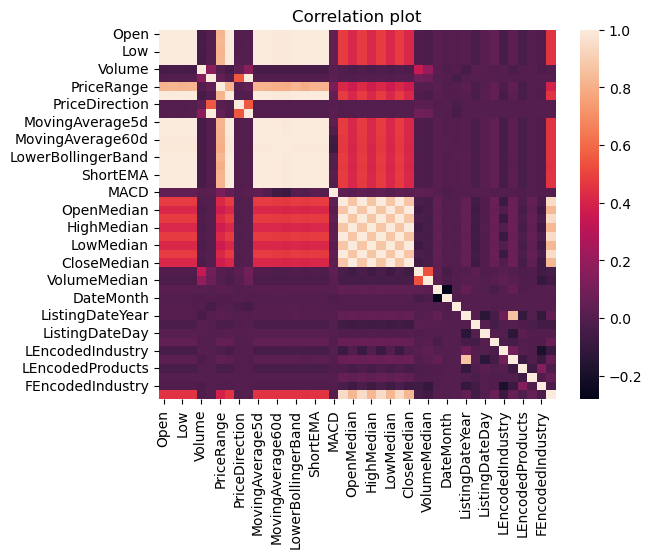

In [10]:
# 회귀 가정 체크 -> 시계열 데이터이다보니 변수(종가, 시가 등)들의 상관관계가 아래와 같이 너무 높습니다.
# 하지만 회귀 가정 중에서는 변수간의 독립성을 고려해야한다는 가정이 존재합니다.
# 따라서 본 시계열 데이터를 바로 회귀모델에 적용하기에는 무리가 있을 수 있습니다.
corr = X_train.corr()
sns.heatmap(corr)

# 시각화를 진행합니다.
plt.title("Correlation plot")
plt.show()

In [11]:
# 일단 독립성에 위배되지만, 모델 결과는 어떻게 나타나는지 sklearn으로 살펴보겠습니다.
lin_reg = LinearRegression()
lin_reg.fit(X_train,Y_train) # sklearn based의 회귀 모델을 적합시킵니다.

LinearRegression()

In [12]:
# 위에서 적합된 모델로 MSE와 R^2를 계산해보겠습니다.
y_pred_sk = lin_reg.predict(X_valid)
J_mse_sk = np.sqrt(mean_squared_error(y_pred_sk, Y_valid))
R_square_sk = lin_reg.score(X_valid,Y_valid)

display(f"RMSE : {J_mse_sk}")
display(f"R square : {R_square_sk}")

'RMSE : 2199.3325219927724'

'R square : 0.9993138728663599'

In [13]:
# 동일한 과정을 statsmodel 패키지로 사용해보겠습니다. 조금 더 디테일한 결과를 얻을 수 있습니다.
# 모델 적합 결과는 sklearn과 동일함을 알 수 있습니다.
model = sm.OLS(Y_train, X_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.856e+07
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:47:38   Log-Likelihood:            -7.8974e+06
No. Observations:              857740   AIC:                         1.579e+07
Df Residuals:                  857703   BIC:                         1.580e+07
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Open                   0.0206      0

- 조금 더 상황에 맞게 해석해보겠습니다.
  1. 모든 회귀 변수의 t statistics와 p-value는 매우 유효하다고 확인되고 있습니다. 모든 변수의 p-value가 0이라고 나오고, t statistics도 매우 크기 때문입니다. `coef`는 회귀 계수의 실질적인 값을 나타냅니다.
  2. 회귀 모델의 전반적인 신뢰도를 나타내는 `f_statistics`도 매우 높으므로, 표본에 대한 회귀 계수들의 설명력은 높은 상태라고 생각할 수 있습니다.
- **하지만 이 회귀모형은 애초에 가정을 만족하지 않는 모형이라는 것을 기억하세요!**

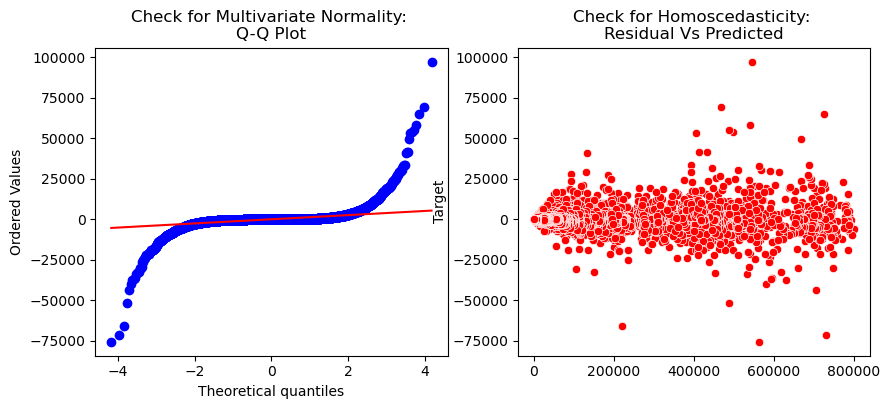

In [14]:
# QQ plot으로 가정을 만족하는지 체크해보겠습니다.
f,ax = plt.subplots(1,2,figsize=(10,4))
_,(_,_,r)= sp.stats.probplot((Y_valid - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

# 등분산성도 체크해보겠습니다.
sns.scatterplot(y = (Y_valid - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r')
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# QQ plot이 비선형적으로 휘어져있고, 등분산성은 다소 만족하는 모습을 보여줍니다.
# QQ plot으로 보아 이는 선형회귀 가정이 만족되고 있지 않음을 보여줍니다.

In [15]:
# VIF를 체크해봐도 터무니없이 높음을 알 수 있습니다. 이는 앞서 확인한 상관계수들과 관련이 있습니다.
VIF = 1/(1- R_square_sk)
display(f"VIF: {VIF}")

# 따라서 본 시계열 데이터는 단순 선형 회귀로는 가정도 만족하지 않을 뿐더러, 적합하지 않습니다.
# 아래 다른 모델들을 더 살펴보도록 하겠습니다.

'VIF: 1457.4558430515108'

In [16]:
# 이론 수업 시간에 KNN은 K가 하이퍼 파라미터로서, K값에 따라 KNN의 성능이 달라질 수 있다는 것을 배웠습니다.
# 따라서 본 실습에서는 이를 관찰하고, 최적의 K값도 찾아보겠습니다. (본 반복문은 18분 정도 소요됩니다.)
knn_db=[]
for i in tqdm(range(3,15,2)):
    M=[]
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(Y_valid, y_pred))   # MSE를 K값에 따라 저장하도록 설정합니다.
    M.append(i)
    M.append(rmse)
    knn_db.append(M)

100%|██████████| 6/6 [00:41<00:00,  6.97s/it]


In [17]:
# 최적의 k값을 찾기 위한 장치입니다. MSE가 가장 작게 나오는 모델을 적합시킨 K값을 최적의 값으로 설정하겠습니다.
min=knn_db[0]
for i in range(len(knn_db)):
    if knn_db[i][1]<min[1]:
        min=knn_db[i]

n=min[0]

# 최적의 K 값이 반환됩니다.
display(n)

3

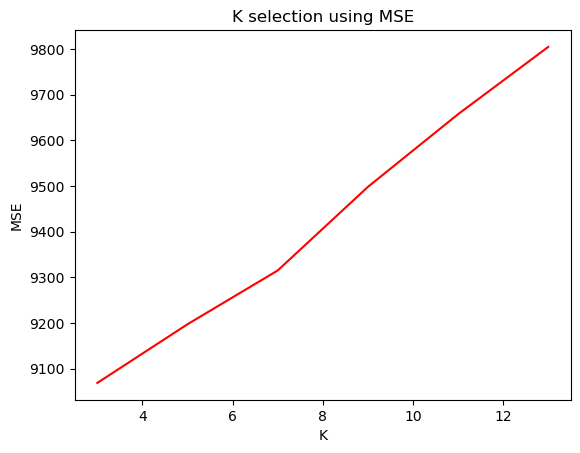

In [18]:
# K값에 따른 MSE 변화를 시각화해보면 아래와 같습니다. K=3일 때 가장 낮은 MSE를 보이는 것을 알 수 있습니다.
# K값이 올라갈수록 MSE가 증가하는 것을 확인할 수 있습니다.
x = [x[0] for x in knn_db]
y = [x[1] for x in knn_db]

# 시각화를 진행합니다.
plt.plot(x, y, color='red')
plt.title('K selection using MSE')
plt.xlabel('K')
plt.ylabel('MSE')
plt.show()

In [19]:
# 위에서 찾은 최적의 K값을 이용해 모델을 학습시켜 결과를 관찰합니다.
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, Y_train)
# ytrainpredict_kk = knn.predict(X_train)     # 시간이 꽤 오래걸리므로 생략하겠습니다.
ytestpredict_kk = knn.predict(X_valid)

In [20]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
display(f'RMSE Test: {np.sqrt(metrics.mean_squared_error(Y_valid, ytestpredict_kk))}')

'RMSE Test: 9068.99087761985'

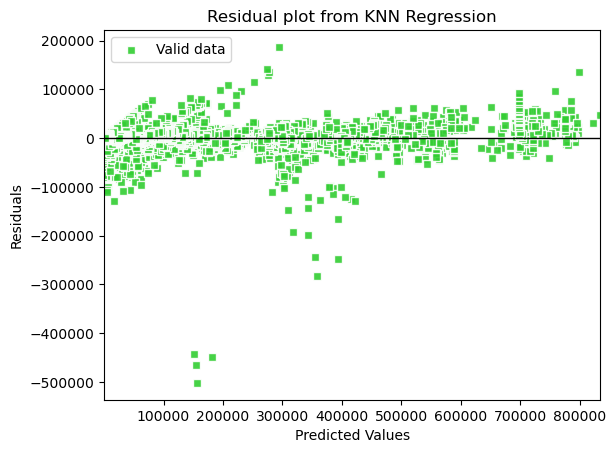

In [21]:
# 모델 적합 결과를 시각화해 보겠습니다. (잔차플롯)
plt.scatter(ytestpredict_kk, ytestpredict_kk-Y_valid, c='limegreen', marker='s', edgecolors='white', s=35, alpha=0.9, label="Valid data")
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=ytestpredict_kk.min()-1, xmax=ytestpredict_kk.max()+1, lw=1, color='black')
plt.xlim([ytestpredict_kk.min()-1, ytestpredict_kk.max()+1])
plt.title('Residual plot from KNN Regression')
plt.show()

In [ ]:
# DecisionTreeRegressor 이용해 의사결정나무를 만듭니다.
dt = DecisionTreeRegressor(
    max_depth=10, # 트리의 깊이를 규제합니다.
    random_state=1214, # 트리의 랜덤시드를 설정합니다.
    min_samples_split=100 # 해당하는 샘플이 100개 이상이면 split하도록 합니다.
    )

dt.fit(X_train, Y_train)
ytrainpredict_df = dt.predict(X_train)
ytestpredict_df = dt.predict(X_valid)

In [ ]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
display(f"RMSE Train: {np.sqrt(metrics.mean_squared_error(Y_train, ytrainpredict_df))}")
display(f"RMSE Test: {np.sqrt(metrics.mean_squared_error(Y_valid, ytestpredict_df))}")

'RMSE Train: 2514.101804387729'

'RMSE Test: 2517.7362100407804'

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.216984 to fit



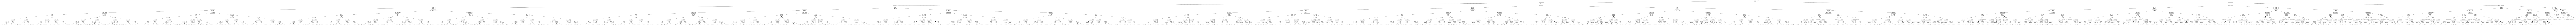

In [ ]:
# 트리를 시각화해보도록 하겠습니다. 트리의 깊이가 깊어지면 시각화에 시간이 오래걸릴 수 있습니다.
export_graphviz(dt, out_file ='tree.dot')
with open("tree.dot") as f:
    dot_graph = f.read()

pydot_graph = pydotplus.graph_from_dot_file("tree.dot")
Image(pydot_graph.create_png())

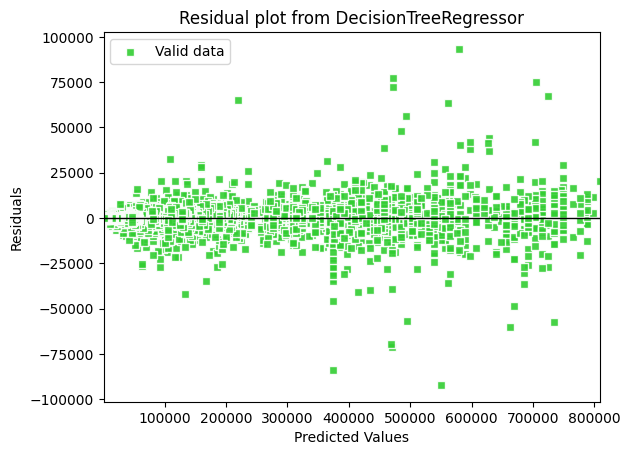

In [ ]:
# 모델 적합 결과를 시각화해 보겠습니다. (잔차플롯)
plt.scatter(ytestpredict_df, ytestpredict_df-Y_valid, c='limegreen', marker='s', edgecolors='white', s=35, alpha=0.9, label="Valid data")
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=ytestpredict_df.min()-1, xmax=ytestpredict_df.max()+1, lw=1, color='black')
plt.xlim([ytestpredict_df.min()-1, ytestpredict_df.max()+1])
plt.title('Residual plot from DecisionTreeRegressor')
plt.show()

In [ ]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
forest_rf = RandomForestRegressor(n_estimators=10, criterion='squared_error', random_state=1, n_jobs=-1)
forest_rf.fit(X_train, Y_train)
ytestpredict_rf = forest_rf.predict(X_valid)

In [ ]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(Y_valid, ytestpredict_rf))}')

RMSE test: 2478.5202941093817


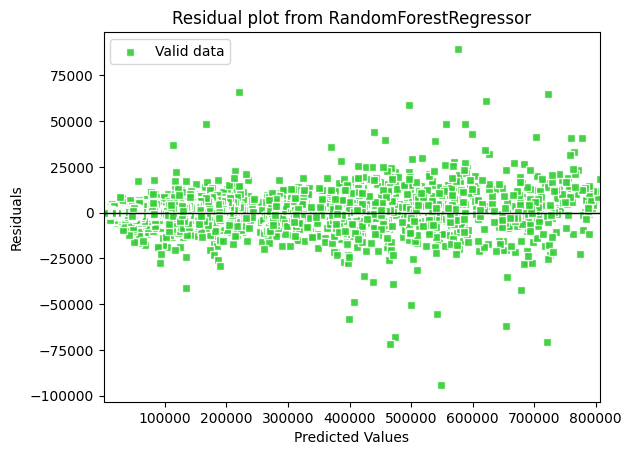

In [ ]:
# 모델 적합 결과를 시각화해 보겠습니다. (잔차플롯)
plt.scatter(ytestpredict_rf, ytestpredict_rf-Y_valid, c='limegreen', marker='s', edgecolors='white', s=35, alpha=0.9, label="Valid data")
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=ytestpredict_rf.min()-1, xmax=ytestpredict_rf.max()+1, lw=1, color='black')
plt.xlim([ytestpredict_rf.min()-1, ytestpredict_rf.max()+1])
plt.title('Residual plot from RandomForestRegressor')
plt.show()